# Forecasting Stock Prices with LSTM and GRU: Deep Learning Based Trading vs. Buy & Hold

Author: Eric Christopher  
Course: Seminar Deep Learning, Wintersemester 2025/2026

In this notebook, we aim to forecast stock prices using deep learning models (LSTM and GRU) and compare a trading strategy based on model predictions against a simple Buy & Hold strategy.

We will use historical stock prices and compute several technical indicators to improve model performance. 

The workflow includes:
- Data Retrieval: Downloading stock prices from Yahoo Finance.  
- Feature Engineering: Calculating technical indicators such as SMA, RSI, MACD, and volatility.  
- Data Preprocessing: Cleaning, scaling, and preparing the data for LSTM/GRU models.  
- Model Training and Hyperparameter Tuning: Building LSTM and GRU networks to forecast future stock prices.  
- Evaluation and Visualization: Comparing predicted prices to actual prices and analyzing performance metrics.  
- Strategy Comparison: Assessing how a prediction-based trading strategy performs compared to Buy & Hold.

We start by importing the necessary Python libraries

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import keras_tuner as kt

## 1. Data Retrieval, Feature Engineering, and Data Preprocessing

To improve the predictive power of our models, we calculate several technical indicators from the raw stock price data. These indicators capture trends, momentum, and volatility, which are important signals for forecasting. We define a function `get_features` to calculate several technical indicators for stock price forecasting:

1. Simple Moving Averages (SMA)
   - SMA5: 5-day moving average, representing short-term price trends.
   - SMA20: 20-day moving average, capturing medium-term trends.

2. Relative Strength Index (RSI)
   - Measures price momentum and identifies overbought or oversold conditions over a 14-day period.
   - Computed based on average gains and losses.

3. Moving Average Convergence Divergence (MACD)
   - Calculated as the difference between the 12-day and 26-day exponential moving averages (EMA).
   - Provides insights into trend direction and momentum shifts.

4. Price Volatility
   - Measured as the 20-day rolling standard deviation of daily percentage returns (pct_change()).
   - Quantifies recent price fluctuations and market uncertainty.

5. Year
   - Extracted from the date index to allow for temporal analysis.

After computing all indicators, rows containing missing values are removed to ensure a clean dataset. The resulting feature matrix is complete, well-structured, and ready for scaling and modeling.

In [7]:
# Function to calculate technical indicators
def get_features(df):
    # Simple Moving Averages
    df["SMA5"] = df["Close"].rolling(5).mean()  # 5-day SMA
    df["SMA20"] = df["Close"].rolling(20).mean()  # 20-day SMA

    # Relative Strength Index (RSI)
    delta = df["Close"].diff()  # Daily price changes
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()  # Average gains over 14 days
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()  # Average losses over 14 days
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))
    
    # Moving Average Convergence Divergence (MACD)
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26

    # Price Volatility
    df["Volatility"] = df["Close"].pct_change().rolling(20).std() # 20-day rolling standard deviation

    # Extract year from date index
    df['Year'] = df.index.year
    
    # Remove rows with missing values after calculations
    df.dropna(inplace=True)
    return df

Next, we define a list of 10 stocks: MSCI, MCD, BA, PFE, INTC, MDLZ, AVY, BXP, ES, APA

For each stock, the following steps are performed:
1. Download historical stock prices from Yahoo Finance (2015-2024).  
2. Apply the `get_features` function to calculate all technical indicators.  
3. Display the first few rows of the dataset.  
4. Check for missing values and duplicate rows.  
5. Display the dataset shape.

These steps ensure that the data is clean, enriched with relevant features, and ready for scaling and modeling.

In [10]:
# List of stocks
stocks = ["MSCI","MCD", "BA", "PFE", "INTC", "MDLZ", "AVY", "BXP", "ES", "APA"]

# For each stock, retrieve price data, calculate key indicators, and check data quality
for stock in stocks:
    print(f"\n{stock}")
    df = yf.download(stock, start="2015-01-01", end="2024-12-31", auto_adjust=True)
    df_features = get_features(df.copy())
    
    # Show the first few rows of the dataset
    print("\nHead of the DataFrame:")
    print(df_features.head())

    # Check for missing values
    print("\nNumber of missing values:")
    print(df_features.isna().sum())

    # Check for duplicate rows
    print("\nNumber of duplicate rows:", df_features.duplicated().sum())

    # Show dataset dimensions
    print(f"\nDataset shape: {df_features.shape[0]} rows, {df_features.shape[1]} columns\n")


MSCI


[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price           Close       High        Low       Open   Volume       SMA5  \
Ticker           MSCI       MSCI       MSCI       MSCI     MSCI              
Date                                                                         
2015-02-02  48.136715  48.207555  47.127226  47.844493   682500  47.968466   
2015-02-03  48.552917  48.685743  48.180998  48.260695   437500  48.065876   
2015-02-04  48.818569  49.146210  48.455507  48.455507   518800  48.285485   
2015-02-05  49.146210  49.580115  48.517493  48.694597   394300  48.462587   
2015-02-06  49.615520  50.261948  49.217040  49.341012  1078800  48.853986   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  46.784973  63.940095  1.284229   0.015986  2015  
2015-02-03  47.121028  55.539843  1.270653   0.015531  2015  
2015-02-04  47.409707  60.228890  1.26672

[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price           Close       High        Low       Open   Volume       SMA5  \
Ticker            MCD        MCD        MCD        MCD      MCD              
Date                                                                         
2015-02-02  70.102142  70.215810  69.283740  69.753565  6751400  69.195824   
2015-02-03  71.170586  71.216056  70.056650  70.200630  7373000  69.855089   
2015-02-04  71.269112  71.557066  70.852331  70.852331  6464800  70.653789   
2015-02-05  71.488869  71.860185  71.231227  71.307003  5564100  70.815955   
2015-02-06  71.223656  71.594972  70.966014  71.344903  4662700  71.050873   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  69.537210  48.100273 -0.297080   0.014771  2015  
2015-02-03  69.601243  53.787205 -0.128404   0.014933  2015  
2015-02-04  69.663760  59.486049  0.01307

[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price            Close        High         Low        Open   Volume  \
Ticker              BA          BA          BA          BA       BA   
Date                                                                  
2015-02-02  127.922318  128.210945  125.114786  125.700782  6790900   
2015-02-03  128.866898  129.444152  127.852332  128.018513  5978200   
2015-02-04  128.761932  129.785239  127.633662  127.668654  4766200   
2015-02-05  129.968948  130.205087  128.097256  128.796944  4252600   
2015-02-06  129.444153  130.222566  129.181763  129.986415  4398800   

Price             SMA5       SMA20        RSI      MACD Volatility  Year  
Ticker                                                                    
Date                                                                      
2015-02-02  124.464055  117.298273  76.915017  3.136686   0.020022  2015  
2015-02-03  127.063432  118.098116  77.528081  3.516177   0.019785  2015  
2015-02-04  128.389354  118.9591

[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price           Close       High        Low       Open    Volume       SMA5  \
Ticker            PFE        PFE        PFE        PFE       PFE              
Date                                                                          
2015-02-02  18.568754  18.568754  18.199139  18.445549  24549979  18.689613   
2015-02-03  18.785828  18.867965  18.457281  18.680223  34785267  18.621557   
2015-02-04  18.981140  19.099513  18.773988  18.921953  38671365  18.668833   
2015-02-05  19.525667  19.649958  19.294839  19.555260  62653660  18.839094   
2015-02-06  19.632198  19.780165  19.371777  19.507906  36868498  19.098717   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  18.936903  37.387514  0.029364   0.011420  2015  
2015-02-03  18.962130  45.312544  0.023721   0.011587  2015  
2015-02-04  18.989496  48.668538 

[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price           Close       High        Low       Open    Volume       SMA5  \
Ticker           INTC       INTC       INTC       INTC      INTC              
Date                                                                          
2015-02-02  25.817268  25.893990  25.050039  25.364603  38733800  25.912403   
2015-02-03  25.855629  26.124158  25.019349  25.917006  36038300  25.837215   
2015-02-04  25.963808  26.149265  25.731989  26.017899  25052800  25.846576   
2015-02-05  26.226536  26.265175  25.847899  26.025627  20491400  25.842499   
2015-02-06  25.731995  26.272908  25.608358  26.211088  29342400  25.919047   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  27.367068  29.485467 -0.505192   0.017444  2015  
2015-02-03  27.280755  30.392227 -0.538252   0.017386  2015  
2015-02-04  27.225553  32.407848 

[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price           Close       High        Low       Open   Volume       SMA5  \
Ticker           MDLZ       MDLZ       MDLZ       MDLZ     MDLZ              
Date                                                                         
2015-02-02  28.015919  28.031588  27.334324  27.608531  7538500  27.967348   
2015-02-03  28.250957  28.321467  28.008089  28.070766  5381100  27.964214   
2015-02-04  28.219618  28.532993  28.133439  28.133439  7244800  28.019056   
2015-02-05  28.407642  28.415478  28.141272  28.211782  7104500  28.100532   
2015-02-06  28.133444  28.423317  28.055101  28.407648  7486800  28.205516   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  28.652860  37.357809 -0.219293   0.012603  2015  
2015-02-03  28.645809  43.595721 -0.212279   0.012355  2015  
2015-02-04  28.646984  43.991094 -0.20686

[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price           Close       High        Low       Open   Volume       SMA5  \
Ticker            AVY        AVY        AVY        AVY      AVY              
Date                                                                         
2015-02-02  41.606647  43.093758  41.143449  42.378646  1785900  42.339645   
2015-02-03  42.118607  42.248627  41.395363  41.419744   917300  42.250254   
2015-02-04  41.850441  42.297387  41.696042  41.761051  1089800  42.185243   
2015-02-05  42.533043  42.728075  41.980454  42.151106   910200  42.116982   
2015-02-06  42.581810  42.882482  42.411155  42.703703   720600  42.138110   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  42.816250  37.900436 -0.007067   0.014829  2015  
2015-02-03  42.843880  42.072407 -0.045294   0.014813  2015  
2015-02-04  42.837379  39.653408 -0.09612

[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price           Close       High        Low       Open   Volume       SMA5  \
Ticker            BXP        BXP        BXP        BXP      BXP              
Date                                                                         
2015-02-02  91.000015  91.116835  88.897166  90.506749  1535600  92.116331   
2015-02-03  92.038429  92.103336  90.221153  90.558650   747100  91.803500   
2015-02-04  91.597092  92.285058  90.928595  91.889152   892100  91.563361   
2015-02-05  93.323540  93.414403  91.889196  92.161786   711400  91.608795   
2015-02-06  91.480286  93.135305  91.038952  93.102852  1007600  91.887872   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  90.756617  55.711651  1.457962   0.011150  2015  
2015-02-03  91.060360  60.667706  1.393604   0.011225  2015  
2015-02-04  91.258636  54.393264  1.29209

[*********************100%***********************]  1 of 1 completed



Head of the DataFrame:
Price           Close       High        Low       Open   Volume       SMA5  \
Ticker             ES         ES         ES         ES       ES              
Date                                                                         
2015-02-02  38.523510  38.578395  37.617882  38.050112  2120300  38.365703   
2015-02-03  38.448036  38.564669  38.207906  38.269653  1569900  38.397263   
2015-02-04  38.153015  38.777350  38.063824  38.249066  1739300  38.390401   
2015-02-05  38.612675  38.695006  38.063810  38.351966  1231700  38.373932   
2015-02-06  36.849461  38.413729  36.575029  38.324538  1859400  38.117339   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  37.665212  75.088867  0.405665   0.008757  2015  
2015-02-03  37.760579  71.932891  0.402431   0.008421  2015  
2015-02-04  37.840163  63.670316  0.37177

[*********************100%***********************]  1 of 1 completed


Head of the DataFrame:
Price           Close       High        Low       Open   Volume       SMA5  \
Ticker            APA        APA        APA        APA      APA              
Date                                                                         
2015-02-02  50.500340  50.500340  48.555964  48.822837  4331900  48.150313   
2015-02-03  51.895718  52.177845  51.125597  51.384844  5681000  48.679489   
2015-02-04  51.323841  52.032966  50.332595  50.843468  6044700  49.623463   
2015-02-05  52.132092  52.665839  51.537337  51.857591  3797900  50.712312   
2015-02-06  52.101597  52.475220  51.361971  52.330343  5016200  51.590717   

Price           SMA20        RSI      MACD Volatility  Year  
Ticker                                                       
Date                                                         
2015-02-02  46.701501  69.634262  0.301328   0.031519  2015  
2015-02-03  47.021393  72.135734  0.603270   0.028118  2015  
2015-02-04  47.337373  68.309232  0.78734

To better understand the dataset and the calculated technical indicators, we generate summary statistics for each stock. 

Each stock contains 2495 trading days covering the period from 2015 to 2024. The Close prices vary significantly across stocks, reflecting different price levels. SMA5 and SMA20 closely follow the Close price, capturing short- and medium-term trends, while RSI values are mostly in the 40-60 range, with occasional extremes indicating overbought or oversold conditions. MACD values differ by stock and provide insight into trend momentum. Volatility is generally low, although some stocks such as APA, BA, and INTC exhibit higher fluctuations.


In [15]:
# Show summary statistics for all features
for stock in stocks:
    df = yf.download(stock, start="2015-01-01", end="2024-12-31", auto_adjust=True)
    df_features = get_features(df.copy())
    print(f"\n Statistical description {stock}:")
    print(df_features.describe())

[*********************100%***********************]  1 of 1 completed



 Statistical description MSCI:
Price         Close         High          Low         Open        Volume  \
Ticker         MSCI         MSCI         MSCI         MSCI          MSCI   
count   2495.000000  2495.000000  2495.000000  2495.000000  2.495000e+03   
mean     291.498151   294.956939   287.916130   291.434910  5.590158e+05   
std      190.903382   193.213262   188.607796   190.984321  5.572511e+05   
min       48.136715    48.207555    47.127226    47.844493  7.760000e+04   
25%       98.573704    99.696880    97.924887    98.847836  3.472000e+05   
50%      248.302521   252.052500   244.731506   247.840816  4.711000e+05   
75%      477.714096   483.050695   471.982463   477.935861  6.600000e+05   
max      645.738159   650.233364   633.294910   646.225892  2.235010e+07   

Price          SMA5        SMA20          RSI         MACD   Volatility  \
Ticker                                                                    
count   2495.000000  2495.000000  2495.000000  2495.00000

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Statistical description MCD:
Price         Close         High          Low         Open        Volume  \
Ticker          MCD          MCD          MCD          MCD           MCD   
count   2495.000000  2495.000000  2495.000000  2495.000000  2.495000e+03   
mean     177.005441   178.290481   175.659719   176.975230  3.820807e+06   
std       65.575636    66.030892    65.098145    65.578993  2.105514e+06   
min       70.102142    70.215810    67.463114    69.753565  9.632000e+05   
25%      126.700199   127.335012   125.893355   126.450614  2.507250e+06   
50%      174.863434   176.360351   172.552038   174.571061  3.221600e+06   
75%      235.160629   236.977674   233.359867   234.979852  4.436150e+06   
max      307.494904   308.796526   305.406476   308.048587  2.528660e+07   

Price          SMA5        SMA20          RSI         MACD   Volatility  \
Ticker                                                                    
count   2495.000000  2495.000000  2495.000000  2495.000000


[*********************100%***********************]  1 of 1 completed


 Statistical description BA:
Price         Close         High          Low         Open        Volume  \
Ticker           BA           BA           BA           BA            BA   
count   2495.000000  2495.000000  2495.000000  2495.000000  2.495000e+03   
mean     212.734843   215.488741   210.047997   212.790777  8.629584e+06   
std       79.580784    80.290084    78.779811    79.563389  1.015931e+07   
min       95.010002    99.419772    89.000000    95.147551  7.889000e+05   
25%      147.154999   149.619995   145.010002   147.327694  3.470300e+06   
50%      196.160004   199.056054   192.929993   196.380005  5.205900e+06   
75%      250.197800   252.220340   247.915554   250.330636  9.313200e+06   
max      430.299957   435.563729   429.880036   435.563729  1.032128e+08   

Price          SMA5        SMA20          RSI         MACD   Volatility  \
Ticker                                                                    
count   2495.000000  2495.000000  2495.000000  2495.000000 


 Statistical description PFE:
Price         Close         High          Low         Open        Volume  \
Ticker          PFE          PFE          PFE          PFE           PFE   
count   2495.000000  2495.000000  2495.000000  2495.000000  2.495000e+03   
mean      27.297308    27.558887    27.033953    27.300083  2.898113e+07   
std        6.574556     6.677360     6.461647     6.565638  1.653345e+07   
min       17.489477    17.746676    17.122629    17.434359  5.187683e+06   
25%       21.885136    22.025490    21.734039    21.872515  1.938970e+07   
50%       25.992226    26.232380    25.715995    26.004544  2.494620e+07   
75%       30.072056    30.282439    29.850202    30.045387  3.354661e+07   
max       49.049423    49.417802    47.912287    48.528905  2.998294e+08   

Price          SMA5        SMA20          RSI         MACD   Volatility  \
Ticker                                                                    
count   2495.000000  2495.000000  2495.000000  2495.000000

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Statistical description INTC:
Price         Close         High          Low         Open        Volume  \
Ticker         INTC         INTC         INTC         INTC          INTC   
count   2495.000000  2495.000000  2495.000000  2495.000000  2.495000e+03   
mean      37.123158    37.562930    36.675170    37.116920  3.309914e+07   
std       10.120217    10.247871     9.992335    10.121683  2.059708e+07   
min       18.889999    19.110001    18.510000    18.969999  5.893800e+06   
25%       28.328802    28.528989    28.011999    28.280964  2.086130e+07   
50%       37.466709    37.886345    37.014739    37.525470  2.805120e+07   
75%       45.110342    45.715171    44.546852    45.108803  3.852050e+07   
max       62.083336    62.292524    60.600826    62.028764  3.008959e+08   

Price          SMA5        SMA20          RSI         MACD   Volatility  \
Ticker                                                                    
count   2495.000000  2495.000000  2495.000000  2495.00000


[*********************100%***********************]  1 of 1 completed

Price         Close         High          Low         Open        Volume  \
Ticker         MDLZ         MDLZ         MDLZ         MDLZ          MDLZ   
count   2495.000000  2495.000000  2495.000000  2495.000000  2.495000e+03   
mean      47.280332    47.663625    46.889979    47.287607  7.566998e+06   
std       12.595476    12.675919    12.515284    12.604731  3.367408e+06   
min       26.903429    27.083621    26.613558    26.919098  1.833800e+06   
25%       35.411839    35.677780    35.178680    35.457667  5.404150e+06   
50%       46.424187    46.754508    46.031702    46.449780  6.795600e+06   
75%       57.982058    58.541598    57.456896    58.002652  8.679700e+06   
max       72.688271    72.901613    72.113138    72.725370  3.465220e+07   

Price          SMA5        SMA20          RSI         MACD   Volatility  \
Ticker                                                                    
count   2495.000000  2495.000000  2495.000000  2495.000000  2495.000000   
mean      47.2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Statistical description BXP:
Price         Close         High          Low         Open        Volume  \
Ticker          BXP          BXP          BXP          BXP           BXP   
count   2495.000000  2495.000000  2495.000000  2495.000000  2.495000e+03   
mean      79.603351    80.460655    78.722662    79.640673  1.017062e+06   
std       15.128600    15.065801    15.149046    15.124609  5.602934e+05   
min       39.850624    41.036321    38.849517    39.253323  1.329000e+05   
25%       68.735405    69.930205    67.666685    68.554969  6.289000e+05   
50%       83.838852    84.642902    83.179699    83.935060  8.669000e+05   
75%       90.948196    91.742495    89.983891    90.895762  1.238050e+06   
max      109.462036   109.699518   108.341522   109.669829  4.745200e+06   

Price          SMA5        SMA20          RSI         MACD   Volatility  \
Ticker                                                                    
count   2495.000000  2495.000000  2495.000000  2495.000000


[*********************100%***********************]  1 of 1 completed


 Statistical description ES:
Price         Close         High          Low         Open        Volume  \
Ticker           ES           ES           ES           ES            ES   
count   2495.000000  2495.000000  2495.000000  2495.000000  2.495000e+03   
mean      56.212898    56.732292    55.657516    56.212346  1.785402e+06   
std       13.684431    13.861178    13.505941    13.698605  8.282679e+05   
min       31.674709    31.897913    31.137604    31.305011  4.945000e+05   
25%       44.132805    44.488282    43.875254    44.155492  1.265500e+06   
50%       55.833912    56.312530    55.376893    55.833902  1.602800e+06   
75%       69.085308    69.757007    68.376951    69.065101  2.087350e+06   
max       81.028107    81.416176    80.709028    81.191973  8.427100e+06   

Price          SMA5        SMA20          RSI         MACD   Volatility  \
Ticker                                                                    
count   2495.000000  2495.000000  2495.000000  2495.000000 

Next, we visualize the Close price along with key technical indicators for each stock. 

The first plot shows the Close price together with the short term (SMA5) and medium term (SMA20) simple moving averages. The second plot displays the Relative Strength Index (RSI), highlighting overbought conditions when above 70 and oversold conditions when below 30.The third plot shows the Moving Average Convergence Divergence (MACD), providing insight into trend momentum.

Finally, the fourth plot shows daily price volatility, which reflects the level of fluctuations and risk for each stock. Volatility sharply increased around 2020 during the COVID-19 pandemic, as markets faced uncertainty from lockdowns, economic disruptions, and changing investor sentiment. After this turbulent period, volatility gradually decreased as markets stabilized and confidence returned.


[*********************100%***********************]  1 of 1 completed


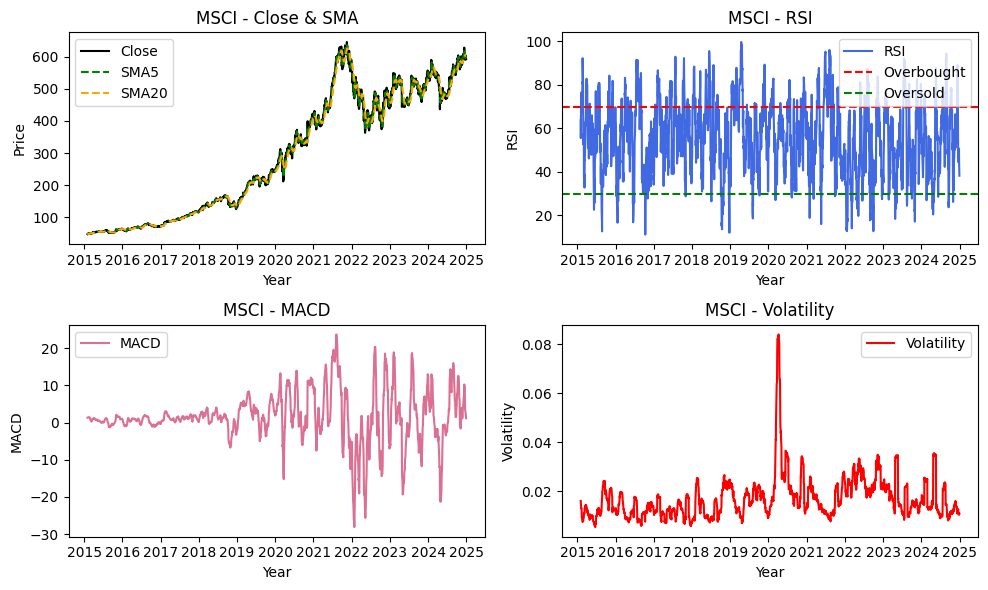

[*********************100%***********************]  1 of 1 completed


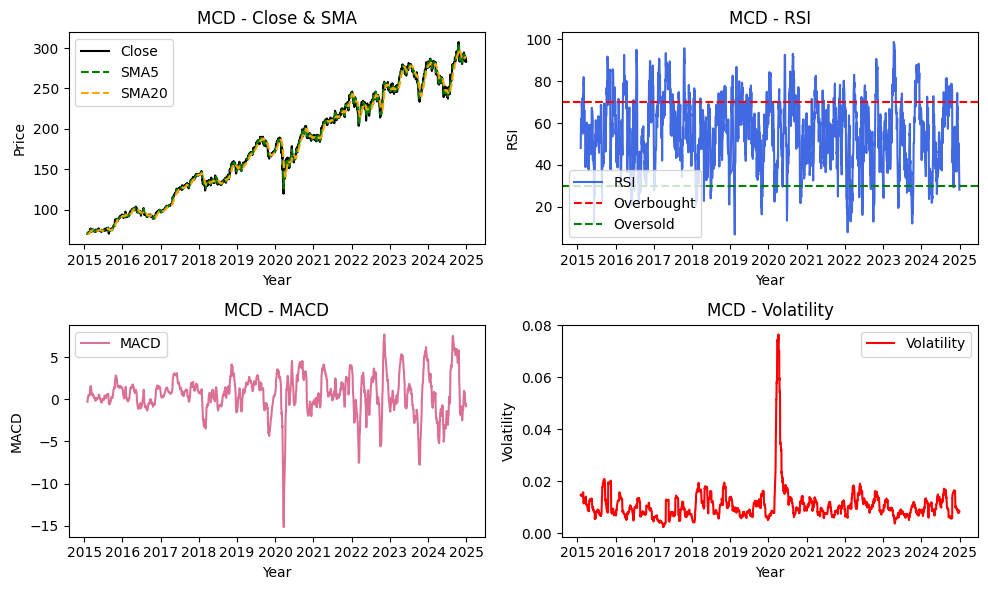

[*********************100%***********************]  1 of 1 completed


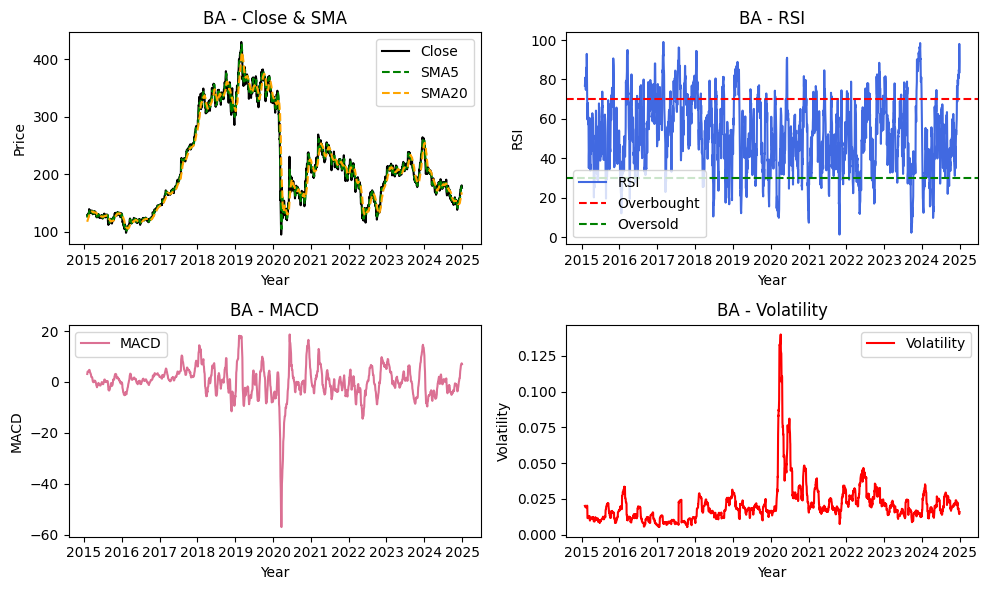

[*********************100%***********************]  1 of 1 completed


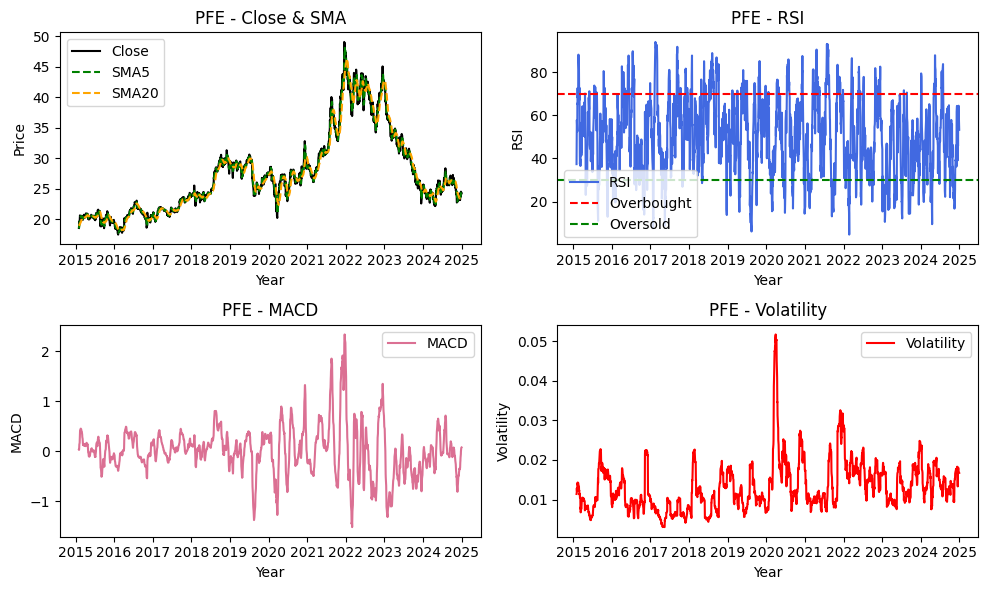

[*********************100%***********************]  1 of 1 completed


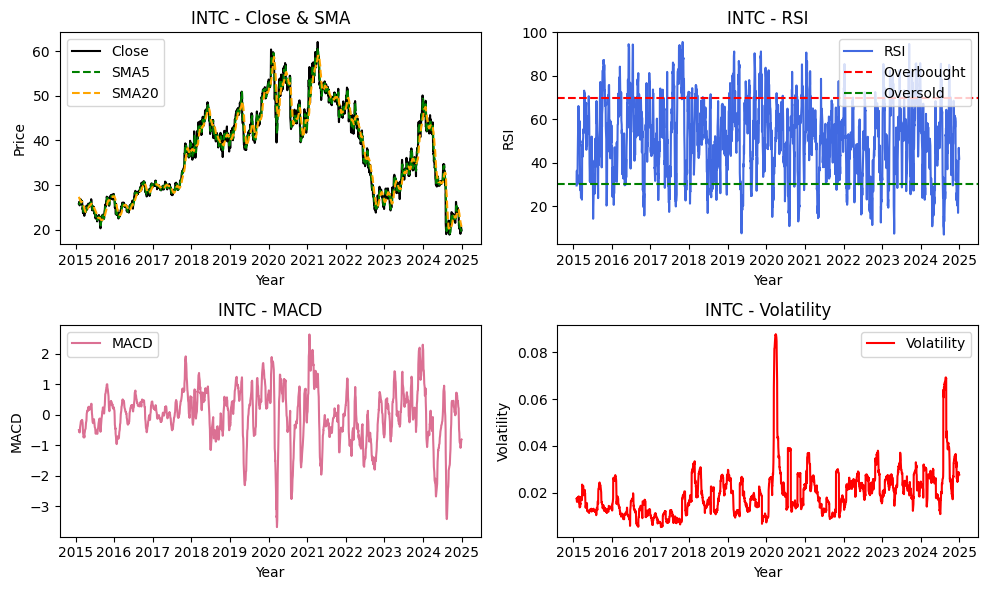

[*********************100%***********************]  1 of 1 completed


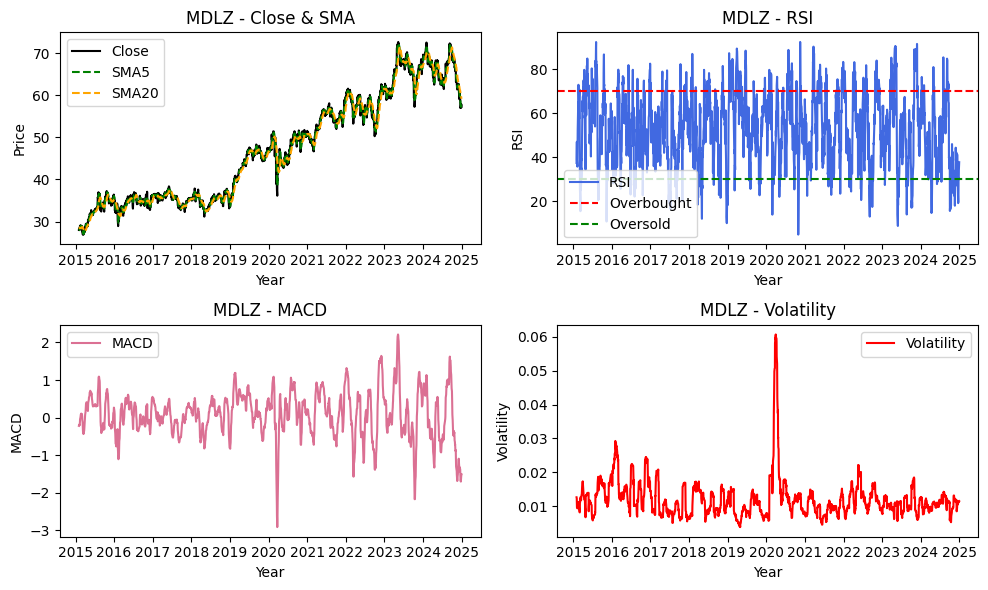

[*********************100%***********************]  1 of 1 completed


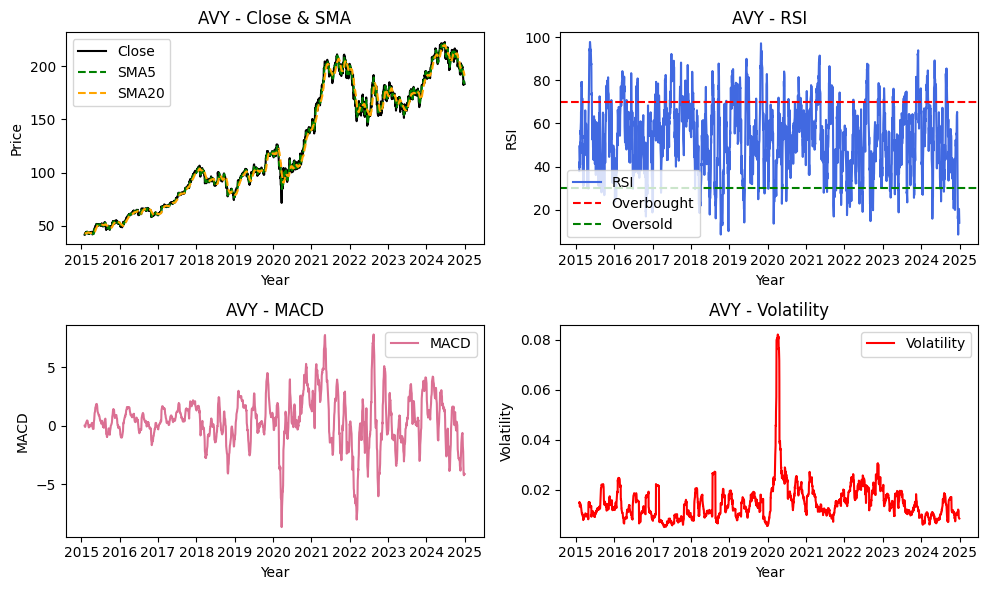

[*********************100%***********************]  1 of 1 completed


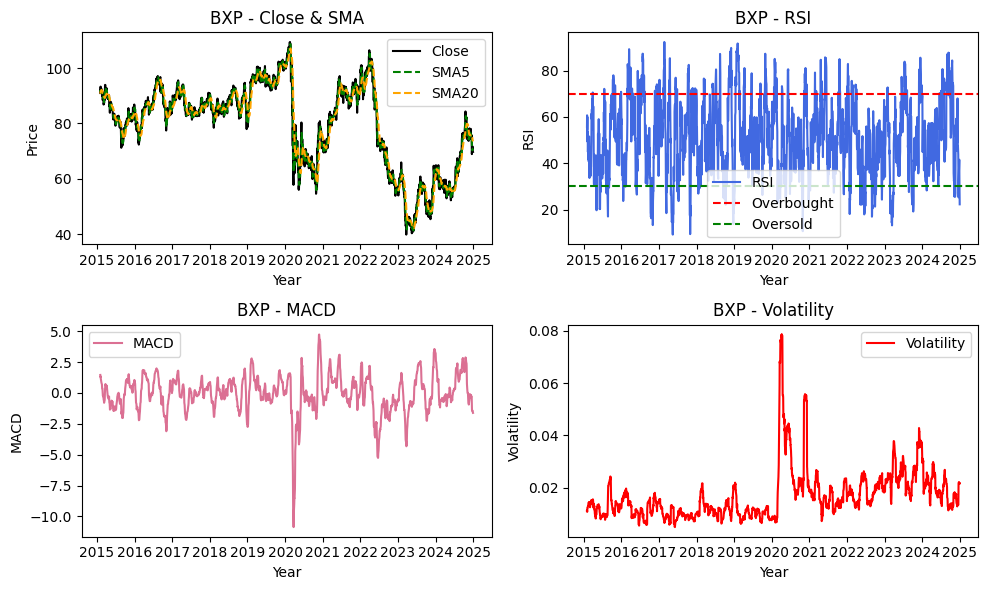

[*********************100%***********************]  1 of 1 completed


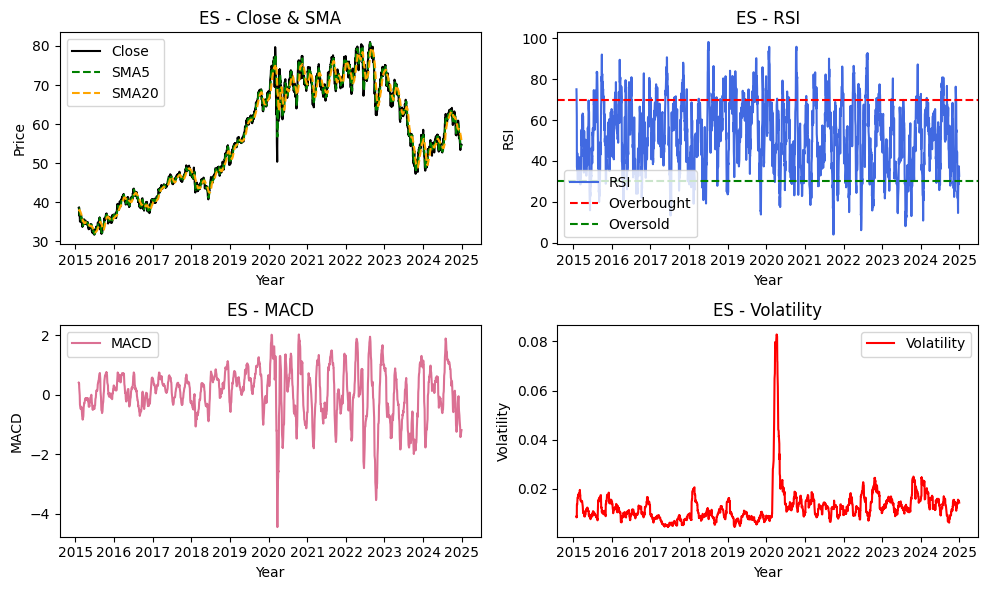

[*********************100%***********************]  1 of 1 completed


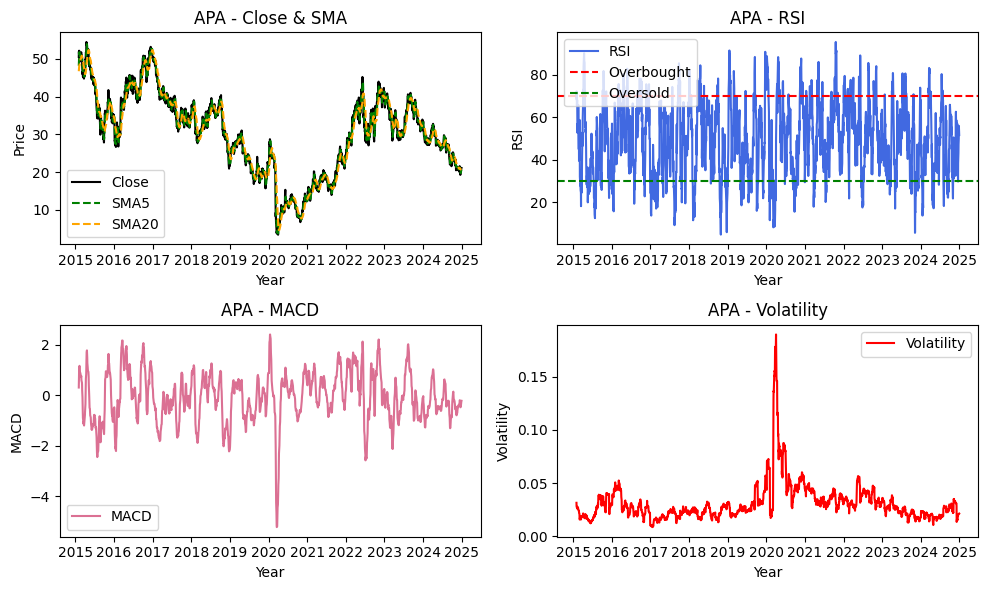

In [18]:
# Function to visualize stock price and key technical indicators
def plot_features(df, stock):
    plt.figure(figsize=(10, 6)) 

    # 1. Close price with short- and medium-term Simple Moving Averages
    plt.subplot(2, 2, 1)
    plt.plot(df.index, df["Close"], color='black', label="Close")
    plt.plot(df.index, df["SMA5"], color='green', label="SMA5", linestyle='dashed')
    plt.plot(df.index, df["SMA20"], color='orange', label="SMA20", linestyle='dashed')
    plt.title(f"{stock} - Close & SMA")
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.legend()

    # 2. Relative Strength Index (RSI)
    plt.subplot(2, 2, 2)
    plt.plot(df.index, df["RSI"], label="RSI", color='royalblue')
    plt.axhline(70, color='red', linestyle='dashed', label="Overbought")
    plt.axhline(30, color='green', linestyle='dashed', label="Oversold")
    plt.title(f"{stock} - RSI")
    plt.xlabel("Year")
    plt.ylabel("RSI")
    plt.legend()

    # 3. Moving Average Convergence Divergence (MACD)
    plt.subplot(2, 2, 3)
    plt.plot(df.index, df["MACD"], label="MACD", color='palevioletred')
    plt.title(f"{stock} - MACD")
    plt.xlabel("Year")
    plt.ylabel("MACD")
    plt.legend()

    # 4. Volatility
    plt.subplot(2, 2, 4)
    plt.plot(df.index, df["Volatility"], label="Volatility", color='red')
    plt.title(f"{stock} - Volatility")
    plt.xlabel("Year")
    plt.ylabel("Volatility")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the Close price and key technical indicators for each stock in the list
for stock in stocks:
    df = yf.download(stock, start="2015-01-01", end="2024-12-31", auto_adjust=True)
    df_features = get_features(df.copy())
    plot_features(df_features, stock=stock)

We define the sequence length and the set of input features used for the forecasting model. The sequence length specifies how many past days are included when predicting the next day’s closing price. We use the selected features (Close, Volume, SMA5, SMA20, RSI, MACD, and Volatility) because they capture essential information about price trends, market momentum, and fluctuations, all of which are valuable for forecasting future price movements.

The `create_sequences` function converts the dataset into input and target pairs suitable for LSTM and GRU models. Each input consists of `seq_length` consecutive days of feature values, while the corresponding target is the closing price of the next day.

In [21]:
# Define sequence length and features for model input
seq_length = 60 # Number of past days to use for predicting the next day's price
features = ["Close", "Volume", "SMA5", "SMA20", "RSI", "MACD", "Volatility"] # Input features

# Function to create sequences for LSTM/GRU models
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length]) # Sequence of past `seq_length = 60` days
        y.append(data[i + seq_length, 0]) # Target is the next day's Close price
    return np.array(X), np.array(y)

## 2. Model Training and Hyperparameter Tuning

We create a function `train_model_rnn` that automates the full training process for both LSTM and GRU models. This function handles everything from building the neural network, performing hyperparameter tuning, training the model, and finally generating predictions.

Inside the function, we create a model setup that outlines the RNN structure and allows Keras Tuner to search over key hyperparameters such as the number of units and the dropout rate. Using the Hyperband optimization algorithm, the tuner identifies the best configuration based on validation loss.

After the optimal hyperparameters are found, the final model is trained using early stopping to prevent overfitting. The function then returns the predictions for the test set.

In [24]:
def build_model(hp, input_shape, rnn_type):
    model = Sequential()
    model.add(Input(shape=input_shape))

    units = hp.Int('units', 100, 200, 50)
    dropout_rate = hp.Float('dropout', 0.0, 0.5, 0.1)

    if rnn_type == 'LSTM':
        model.add(LSTM(units=units, return_sequences=False))
    else:
        model.add(GRU(units=units, return_sequences=False))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
    
def train_model_rnn(X_train, y_train, X_val, y_val, X_test, y_test, rnn_type, stock):

    input_shape = (X_train.shape[1], X_train.shape[2])

    # Tuning with build_model
    tuner = kt.Hyperband(
        lambda hp: build_model(hp, input_shape, rnn_type),
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='hyperparameter_tuning',
        project_name=f'{stock}_{rnn_type}_tuning'
    )

    # Find the best hyperparameters
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Display best hyperparameters
    print(f"\nBest Hyperparameters for {rnn_type}")
    print(f"Units: {best_hps.get('units')}")
    print(f"Dropout Rate: {best_hps.get('dropout')}")

    # Build final model with best hyperparameters
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model = build_model(best_hps, input_shape, rnn_type)

    # Train the model on the training data with early stopping to prevent overfitting
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stop])

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Return the predicted values
    return y_pred

## 3. Evaluation and Visualization

To evaluate how the model’s predictions can be used in a practical trading strategy, we create a function that converts predicted prices into trading signals. The function `generate_trading_signals` compares each predicted price to the previous day’s actual closing price and determines whether to buy, hold, sell, or take no action.

The logic is based on a simple rule: The trading signals are generated based on the predicted price compared to yesterday’s actual price. If the predicted price is higher and no position is held, the model issues a Buy signal. If a position is already held, it issues a Hold signal. Conversely, if the predicted price is lower or equal and a position is held, the model issues a Sell signal. If no position is held, it issues No Action.

This process produces a sequence of trading decisions that will later be used to simulate the strategy’s performance and compare it with a traditional buy-and-hold approach.

In [27]:
# Function to generate trading signals based on model predictions
def generate_trading_signals(y_true, y_pred):
    signals = []
    position = False # True if currently holding a position
    for i in range(1, len(y_pred)):
       # Check if the predicted price indicates an increase over yesterday's close
        if y_pred[i] > y_true[i-1]:
            if not position:
                signals.append("Buy") # Buy if not holding a position
                position = True
            else:
                signals.append("Hold") # Hold if already in position
        else:
            # Check if the predicted price indicates a decline compared to yesterday's close
            if position:
                signals.append("Sell") # Sell if currently holding a position
                position = False
            else:
                signals.append("No Action") # Do nothing if not holding a position
    signals.insert(0, "No Action")  # First day no action
    # Return the signals
    return signals

In the `calculate_strategy_returns` function, the portfolio value is calculated by simulating trades based on the generated signals. When the signal is Buy or Sell trades are executed at the day’s opening price, subtracting the trading fees. The portfolio value is then updated daily using the actual closing prices. 

The `calculate_buy_hold_returns` function calculates the Buy & Hold strategy by purchasing shares at the first day’s open price and holding them until the end, also considering the trading fees at purchase. This allows us to compare the returns of an active trading strategy with those of a passive investment approach.

In [30]:
# Function to calculate portfolio value based on trading signals
def calculate_strategy_returns(y_true, signals, open_prices, start_capital,trade_cost):
    
    # y_true: actual Close prices (for valuation)
    # open_prices: actual Open prices (for trade execution)
    
    cash = start_capital # Initialize cash with starting capital
    position = 0 # No stock holdings at the beginning
    portfolio_value = [] # List to store portfolio value over time
    
    for i in range(len(signals)):
        signal = signals[i]
        # Execute trades based on signals at today's open price
        if signal == "Buy" and position == 0:
            position = (cash - trade_cost) / open_prices[i] # Purchase shares using remaining cash after deducting trade cost
            cash = 0
        elif signal == "Sell" and position > 0:
            cash += position * open_prices[i] - trade_cost  # Sell all shares and deduct trade cost
            position = 0
        # Update portfolio value using today's closing price
        total_value = cash + position * y_true[i]
        portfolio_value.append(total_value.item())
    # Return portfolio value 
    return np.array(portfolio_value, dtype=float)

# Function to calculate Buy & Hold strategy returns
def calculate_buy_hold_returns(y_true, open_prices, start_capital,trade_cost):
     # Buy at first day's open price, subtracting trade cost, and hold until the end
    position = (start_capital - trade_cost) / open_prices[0]
    # Return portfolio value history
    return position * y_true

To quantify the risk of the trading strategies, the function calculates the Historical Value at Risk (VaR) at the 5% level. Value at Risk measures the potential loss in portfolio value over a given time period, under normal market conditions, with a certain confidence level.

In [33]:
# Function to calculate daily returns from portfolio values
def calculate_daily_returns(portfolio_values):
    return np.diff(portfolio_values) / portfolio_values[:-1]

# Function to calculate Historical VaR at 95% confidence level
def historical_var(returns, confidence_level=0.05):
    return np.percentile(returns, 100 * confidence_level)

Next, we create a function named `train_and_predict_lstm_gru` that performs the entire workflow for a given stock. The function downloads historical stock data, calculates the selected features, splits the data into training and test sets, scales the features, and creates sequences for RNN input. It then trains both LSTM and GRU models with hyperparameter tuning, makes predictions, and rescales the predicted values back to the original price scale.

We apply MinMaxScaler to normalize the data because LSTM and GRU models perform better when input features are on a similar scale. Scaling all values between 0 and 1 prevents features with larger magnitudes from dominating the learning process, stabilizes and speeds up training, and helps the model capture temporal patterns more effectively. This approach ensures that features such as price, volume, and technical indicators are treated consistently during learning.

After generating predictions, the function calculates error metrics including MAE (Mean Absolute Error), MSE (Mean Squared Error), and RMSE (Root Mean Squared Error) for both models to evaluate prediction accuracy. It then generates trading signals based on the predicted prices and executes trades at the actual Open prices. The portfolio simulation assumes a starting capital of 5.000 USD and a flat trading fee of 1 USD per trade, reflecting real-world conditions similar to platforms like Trade Republic. The function computes portfolio values for each strategy and compares them with a passive Buy & Hold approach.

To quantify the risk of the trading strategies, the function calculates the Historical Value at Risk (VaR) at the 5% level. A 5% Historical VaR indicates the maximum expected loss that could occur on the worst 5% of trading days. By comparing VaR across the LSTM strategy, GRU strategy, and Buy & Hold, we can assess not only potential returns but also the downside risk associated with each approach.

Finally, the function visualizes the results, showing predicted vs actual prices and the portfolio performance over time.

In [36]:
# Main function to run training, prediction, and strategy evaluation (single-stock portfolio)
def train_and_predict_lstm_gru(stock):
    print(f"\nStarting model for {stock}")
    df = yf.download(stock, start="2015-01-01", end="2024-12-31", auto_adjust=True)
    df = get_features(df) 

    # Split into training and test sets
    train_df = df[df['Year'] <= 2022]
    test_df = df[df['Year'] >= 2023]

    train_data = train_df[features].values
    test_data = test_df[features].values

    # Scale features between 0 and 1
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Create sequences for RNN input
    X_train_full, y_train_full = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # Split in Training und Validation
    X_train, X_val, y_train, y_val = train_test_split( X_train_full, y_train_full, test_size=0.2, shuffle=False)

    # Train LSTM and GRU models
    y_pred_lstm = train_model_rnn(X_train, y_train, X_val, y_val, X_test, y_test, rnn_type='LSTM', stock=stock)
    y_pred_gru = train_model_rnn(X_train, y_train, X_val, y_val, X_test, y_test, rnn_type='GRU', stock=stock)

    # Rescale predictions back to original Close price
    close_min = scaler.data_min_[0]
    close_max = scaler.data_max_[0]

    def inverse_close(x):
        return x * (close_max - close_min) + close_min

    y_test_rescaled = inverse_close(y_test)
    y_pred_lstm_rescaled = inverse_close(y_pred_lstm.flatten())
    y_pred_gru_rescaled  = inverse_close(y_pred_gru.flatten())

    # Calculate Error metrics
    for name, y_pred_res in [('LSTM', y_pred_lstm_rescaled), ('GRU', y_pred_gru_rescaled)]:
        mae = mean_absolute_error(y_test_rescaled, y_pred_res)
        mse = mean_squared_error(y_test_rescaled, y_pred_res)
        rmse = math.sqrt(mse)
        print(f"\n{name} Error Metrics:")
        print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

    # Generate trading signals and preview results
    signals_lstm = generate_trading_signals(y_test_rescaled, y_pred_lstm_rescaled)
    signals_gru = generate_trading_signals(y_test_rescaled, y_pred_gru_rescaled)
    print("\nFirst 10 LSTM Signals:", signals_lstm[:10])
    print("\nFirst 10 GRU Signals:", signals_gru[:10])

    # Open prices are used for executing buy/sell trades (Close prices for valuation)
    open_prices_test = test_df["Open"].iloc[seq_length:].values
    open_prices_test = open_prices_test.flatten()[:len(signals_lstm)]

    # Simulate trading strategies and compute single-stock portfolio values
    # Each strategy starts with 5000 USD capital and includes a fixed transaction cost of 1 USD per trade
    strategy_lstm = calculate_strategy_returns(y_test_rescaled, signals_lstm, open_prices_test, start_capital=5000,trade_cost=1)
    strategy_gru  = calculate_strategy_returns(y_test_rescaled, signals_gru,  open_prices_test, start_capital=5000,trade_cost=1)
    buy_hold = calculate_buy_hold_returns(y_test_rescaled, open_prices_test, start_capital=5000,trade_cost=1)
    print(f"\nFinal portfolio value (LSTM strategy): {strategy_lstm[-1]:.2f}")
    print(f"\nFinal portfolio value (GRU strategy): {strategy_gru[-1]:.2f}")
    print(f"\nFinal portfolio value (Buy & Hold): {buy_hold[-1]:.2f}")

    # Calculate single-stock portfolio return in %
    start_capital = 5000
    return_lstm = (strategy_lstm[-1] - start_capital) / start_capital * 100
    return_gru = (strategy_gru[-1] - start_capital) / start_capital * 100
    return_buy_hold = (buy_hold[-1] - start_capital) / start_capital * 100

    print(f"\nTotal Return (%):")
    print(f"LSTM Strategy: {return_lstm:.2f}%")
    print(f"GRU Strategy: {return_gru:.2f}%")
    print(f"Buy & Hold: {return_buy_hold:.2f}%")

    # Calculate daily returns
    returns_lstm = calculate_daily_returns(strategy_lstm)
    returns_gru = calculate_daily_returns(strategy_gru)
    returns_buy_hold = calculate_daily_returns(buy_hold)

    # Calculate Historical VaR (5%)
    var_lstm = historical_var(returns_lstm, 0.05)
    var_gru = historical_var(returns_gru, 0.05)
    var_buy_hold = historical_var(returns_buy_hold, 0.05)

    print(f"\n5% Historical VaR:")
    print(f"LSTM Strategy: {var_lstm:.4f}")
    print(f"GRU Strategy: {var_gru:.4f}")
    print(f"Buy & Hold: {var_buy_hold:.4f}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    # Plot 1: Comparison between actual prices and model predictions
    axes[0].plot(y_test_rescaled, label="Actual Price", color='black')
    axes[0].plot(y_pred_lstm_rescaled, label="LSTM Prediction", linestyle='dashed', color='blue')
    axes[0].plot(y_pred_gru_rescaled, label="GRU Prediction", linestyle='dashed', color='red')
    axes[0].set_title(f"{stock} - Actual vs Predicted Prices (LSTM & GRU)")
    axes[0].set_xlabel("Trading Days")
    axes[0].set_ylabel("Stock Price ($)")  
    axes[0].legend()
    axes[0].grid(True)
    # Plot 2: Single-stock portfolio value over time for each strategy
    axes[1].plot(strategy_lstm, label="LSTM Strategy", linestyle='dashed', color='blue')
    axes[1].plot(strategy_gru, label="GRU Strategy", linestyle='dashed', color='red')
    axes[1].plot(buy_hold, label="Buy & Hold", linestyle='dashed', color='green')
    axes[1].set_title(f"{stock} - Strategy Performance (LSTM, GRU, Buy & Hold)")
    axes[1].set_xlabel("Trading Days")
    axes[1].set_ylabel("Portfolio Value ($)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    print(len(y_test_rescaled), len(signals_lstm), len(open_prices_test))

## 4. Strategy Comparison

Finally, we run the `train_and_predict_lstm_gru` function for a specific stock, which executes the full workflow including data preparation, model training, prediction, trading signal generation, portfolio simulation, and visualization.

[*********************100%***********************]  1 of 1 completed


Starting model for MSCI


Reloading Tuner from hyperparameter_tuning\MSCI_LSTM_tuning\tuner0.json

Best Hyperparameters for LSTM
Units: 100
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0199 - val_loss: 0.0021
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.8600e-04 - val_loss: 0.0015
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.6084e-04 - val_loss: 0.0014
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.5443e-04 - val_loss: 0.0014
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.5023e-04 - val_loss: 0.0013
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.2326e-04 - val_loss: 0.0013
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.4544e-04 - val_loss: 0.0012
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.6163e-04 - val_loss: 0.0011
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.1361e-04 - val_loss: 0.0013
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.2594e-04 

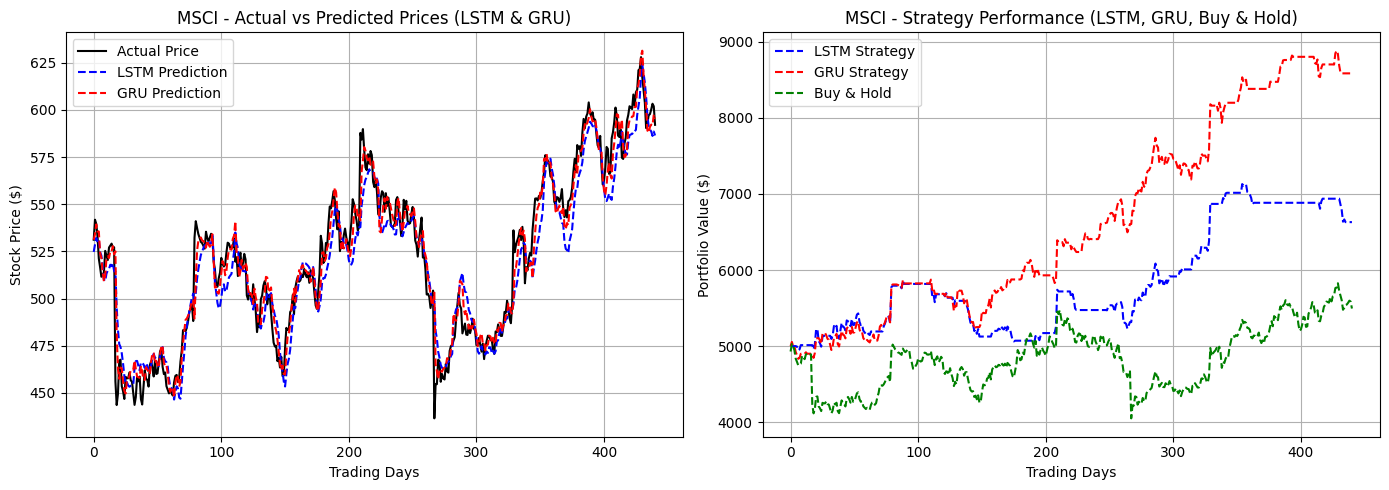

441 441 441


In [39]:
# Run the LSTM and GRU models, and evaluate trading strategies for MSCI stock
train_and_predict_lstm_gru("MSCI")

[*********************100%***********************]  1 of 1 completed


Starting model for MCD
Reloading Tuner from hyperparameter_tuning\MCD_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0194 - val_loss: 0.0011
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 2.9761e-04 - val_loss: 6.9900e-04
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 2.9107e-04 - val_loss: 6.4339e-04
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 3.1422e-04 - val_loss: 6.4415e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 2.6970e-04 - val_loss: 6.0515e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 2.0884e-04 - val_loss: 0.0012
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 2.9038e-04 - val_loss: 5.6247e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 2.2071e-04 - val_loss: 5.4133e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 2.4604e-04 - val_loss: 6.6187e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 2.1999e-04 - val_loss: 5.4041e-04
Epoch 11/20
49/49 ━━

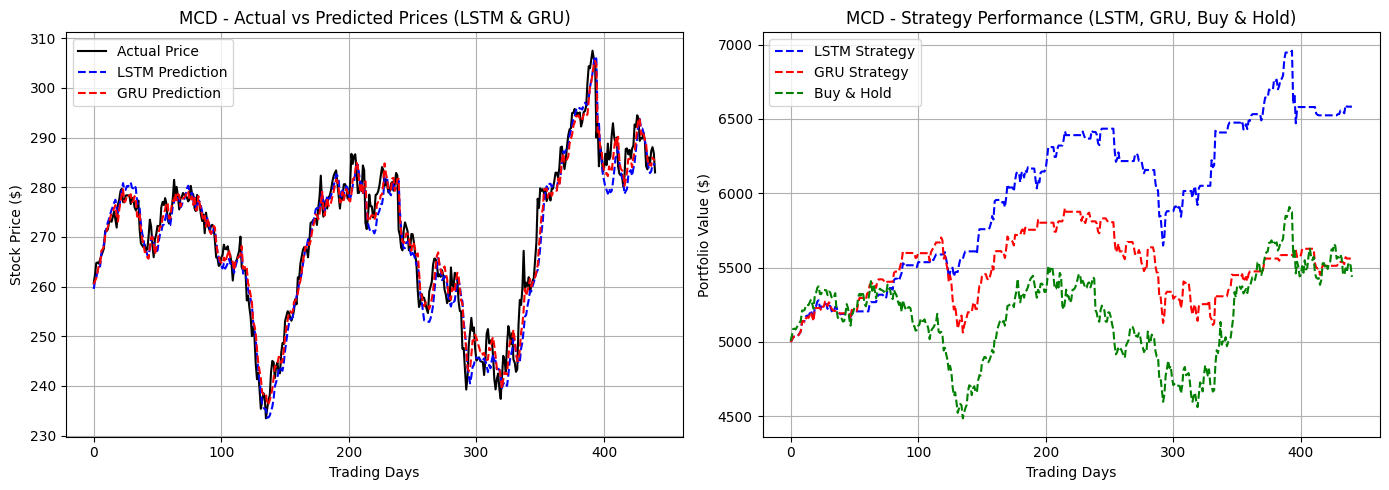

441 441 441


In [47]:
# Run the LSTM and GRU models, and evaluate trading strategies for McDonald's stock
train_and_predict_lstm_gru("MCD")

[*********************100%***********************]  1 of 1 completed


Starting model for BA
Reloading Tuner from hyperparameter_tuning\BA_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.30000000000000004
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0348 - val_loss: 7.8459e-04
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0032 - val_loss: 7.4671e-04
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0028 - val_loss: 6.3564e-04
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0022 - val_loss: 5.9055e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0021 - val_loss: 7.0943e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0022 - val_loss: 7.0649e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0018 - val_loss: 9.7883e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0024 - val_loss: 4.4632e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0017 - val_loss: 5.1840e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0017 - val_loss: 4.7603e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━

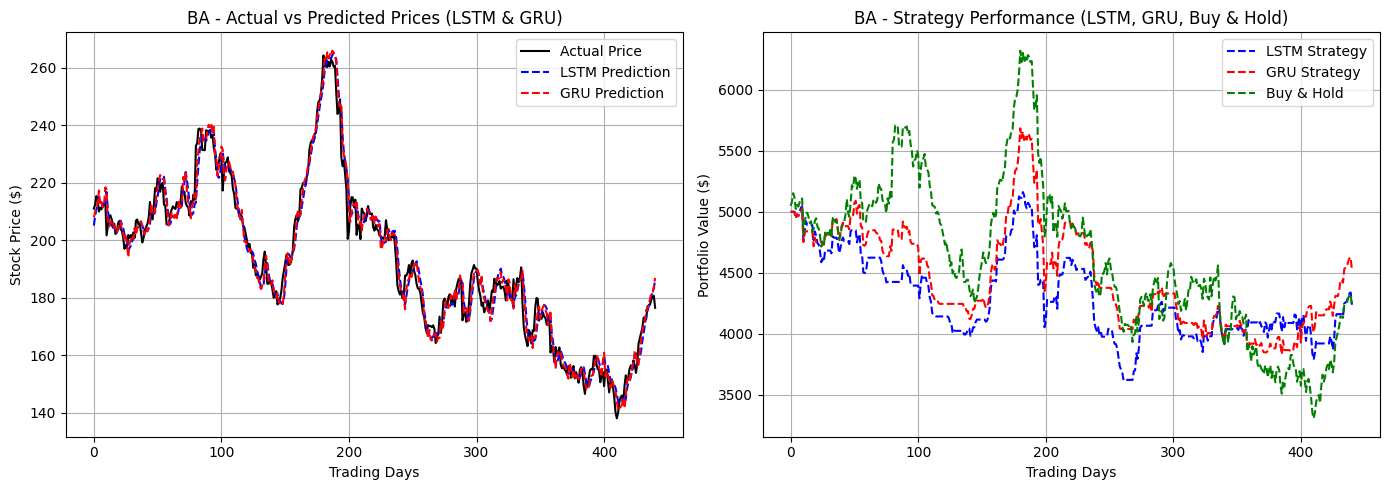

441 441 441


In [49]:
# Run the LSTM and GRU models, and evaluate trading strategies for Boeing stock
train_and_predict_lstm_gru("BA")

[*********************100%***********************]  1 of 1 completed


Starting model for PFE


Reloading Tuner from hyperparameter_tuning\PFE_LSTM_tuning\tuner0.json

Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 3.8053e-04 - val_loss: 0.0030
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 3.0837e-04 - val_loss: 0.0032
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 3.7343e-04 - val_loss: 0.0019
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 2.8049e-04 - val_loss: 0.0033
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 2.8975e-04 - val_loss: 0.0036
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 2.8856e-04 - val_loss: 0.0019
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 2.3797e-04 - val_loss: 0.0022
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 2.5715e-04 - val_loss: 0.0018
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 2.3135e-04 -

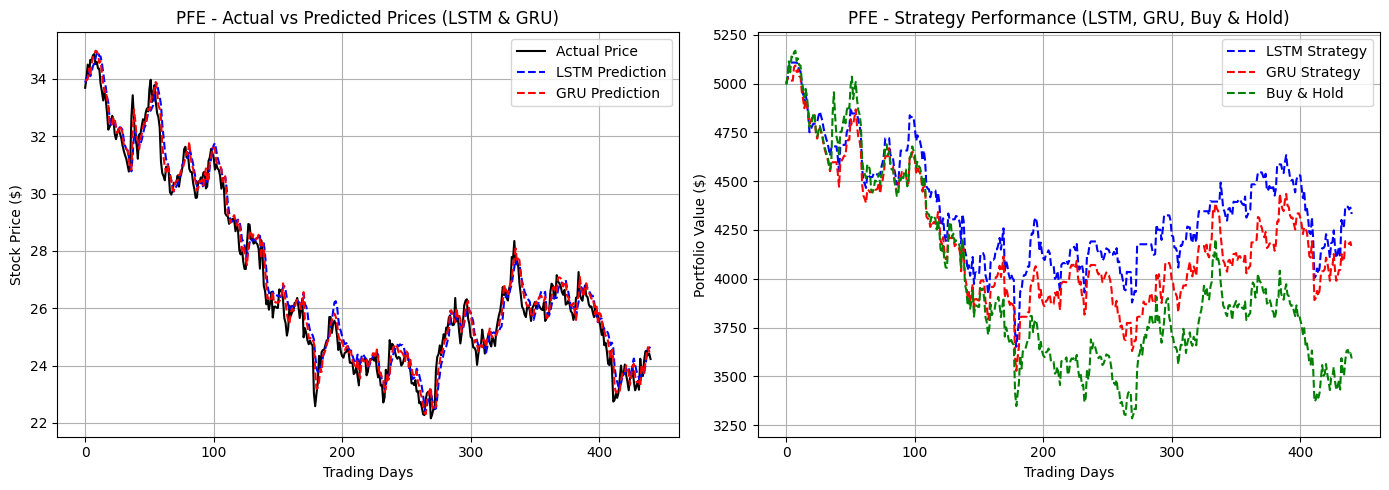

441 441 441


In [51]:
# Run the LSTM and GRU models, and evaluate trading strategies for Pfizer stock
train_and_predict_lstm_gru("PFE")

[*********************100%***********************]  1 of 1 completed


Starting model for INTC
Reloading Tuner from hyperparameter_tuning\INTC_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.1
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0266 - val_loss: 0.0016
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0013 - val_loss: 9.1630e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0012 - val_loss: 9.0504e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0011 - val_loss: 8.5568e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0010 - val_loss: 8.4491e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 9.8527e-04 - val_loss: 8.0834e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 9.500

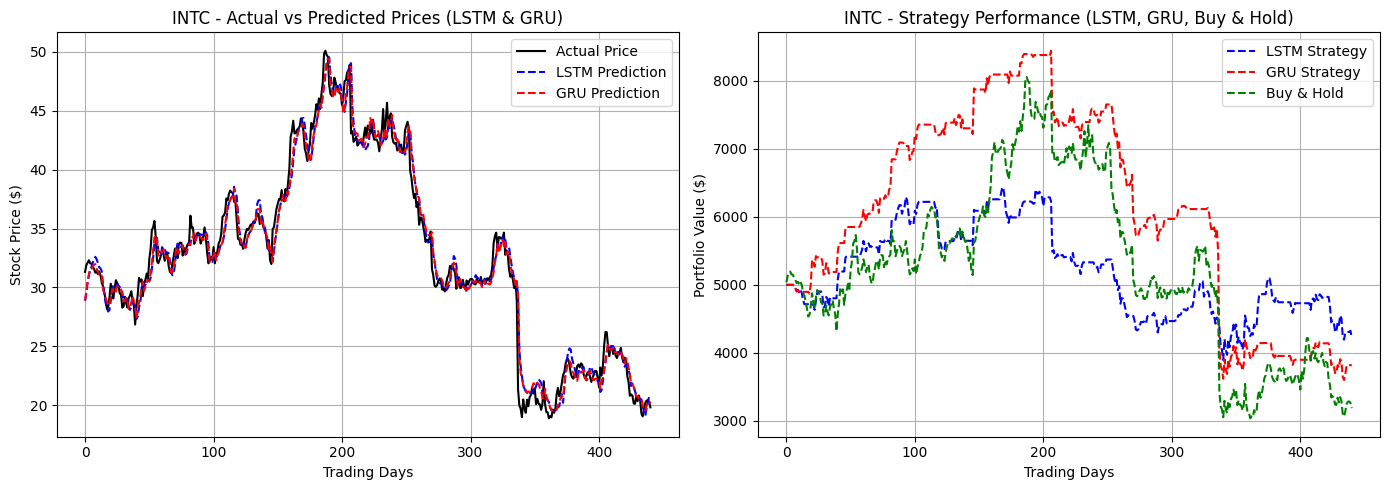

441 441 441


In [64]:
# Run the LSTM and GRU models, and evaluate trading strategies for Intel stock
train_and_predict_lstm_gru("INTC")

[*********************100%***********************]  1 of 1 completed


Starting model for MDLZ
Reloading Tuner from hyperparameter_tuning\MDLZ_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 100
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0270 - val_loss: 0.0023
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 7.7670e-04 - val_loss: 0.0014
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 6.6934e-04 - val_loss: 0.0012
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 6.6749e-04 - val_loss: 0.0014
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 7.1489e-04 - val_loss: 9.6036e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 6.2574e-04 - val_loss: 9.2480e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.2879e-04 - val_loss: 8.7003e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 5.1517e-04 - val_loss: 9.3416e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.3415e-04 - val_loss: 0.0011
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.0468e-04 - val_loss: 9.2804e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━

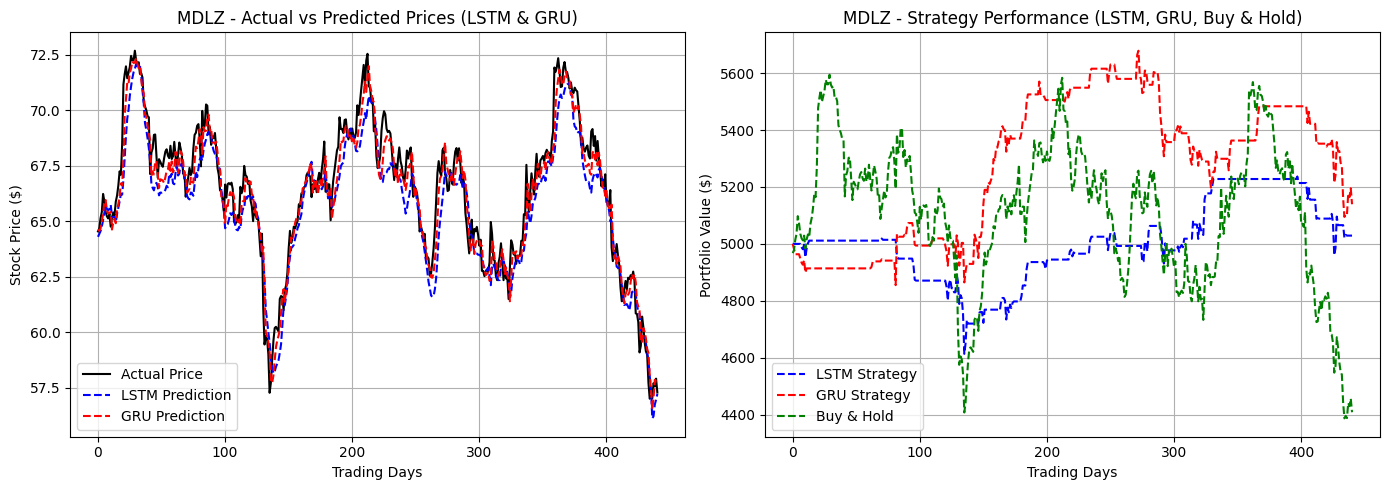

441 441 441


In [66]:
# Run the LSTM and GRU models, and evaluate trading strategies for Mondelez stock
train_and_predict_lstm_gru("MDLZ")

[*********************100%***********************]  1 of 1 completed


Starting model for AVY
Reloading Tuner from hyperparameter_tuning\AVY_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 100
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0236 - val_loss: 0.0012
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 3.3674e-04 - val_loss: 0.0013
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.5266e-04 - val_loss: 0.0011
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.5945e-04 - val_loss: 0.0010
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2.7183e-04 - val_loss: 9.4647e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.1337e-04 - val_loss: 0.0010
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2.4683e-04 - val_loss: 9.5197e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2.5843e-04 - val_loss: 0.0010
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.2561e-04 - val_loss: 8.8036e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.7606e-04 - val_loss: 8.5696e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━

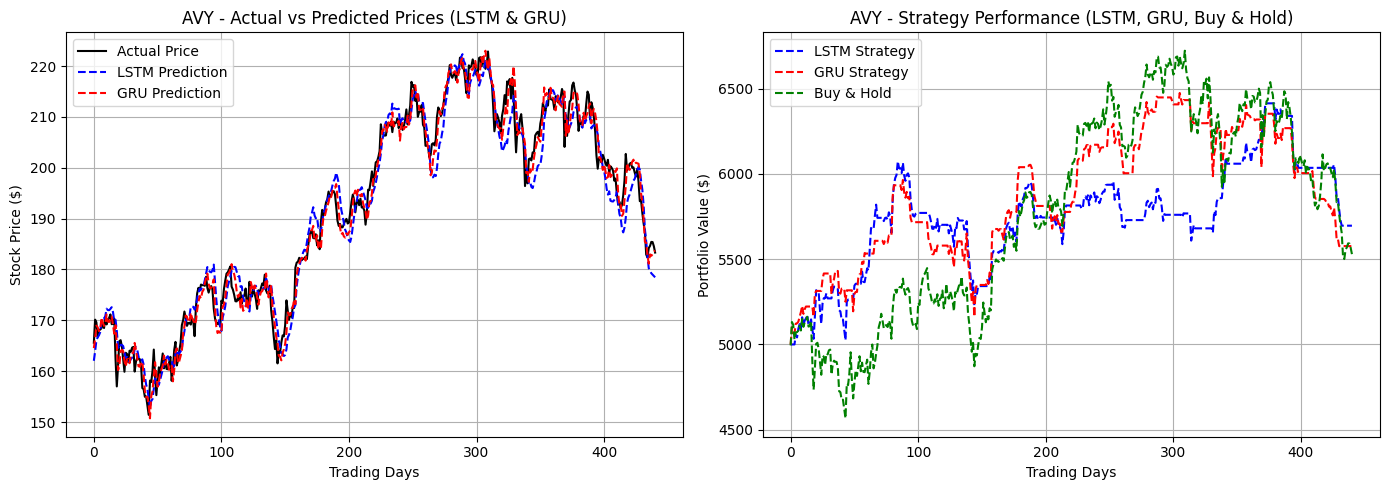

441 441 441


In [70]:
# Run the LSTM and GRU models, and evaluate trading strategies for Avery Dennison Corporation stock
train_and_predict_lstm_gru("AVY")

[*********************100%***********************]  1 of 1 completed


Starting model for BXP


Reloading Tuner from hyperparameter_tuning\BXP_LSTM_tuning\tuner0.json

Best Hyperparameters for LSTM
Units: 150
Dropout Rate: 0.30000000000000004
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0443 - val_loss: 0.0041
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0029 - val_loss: 0.0023
Ep

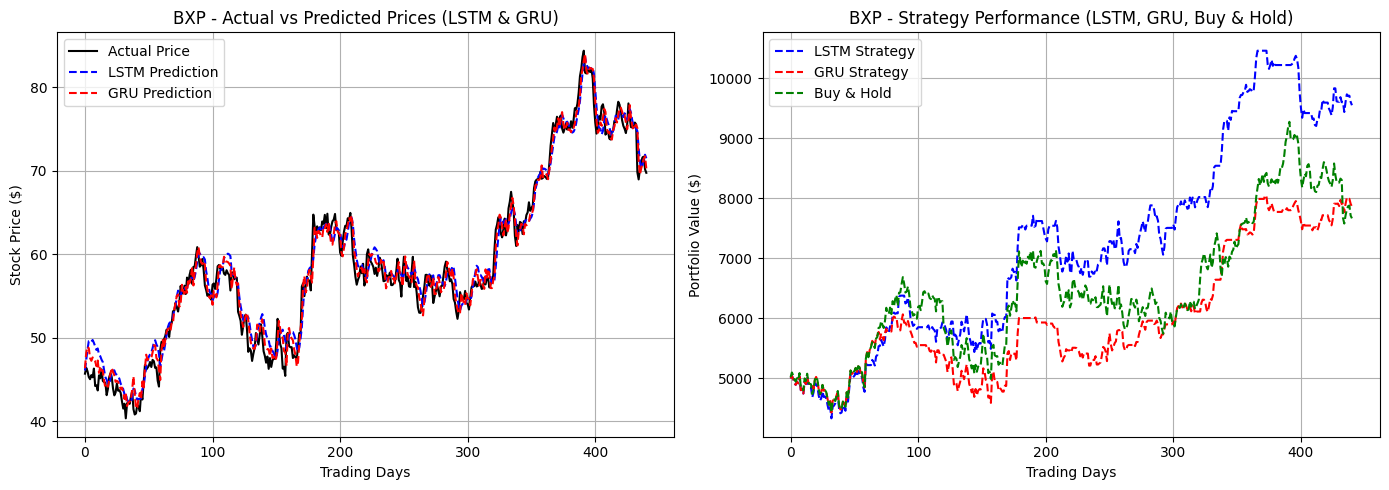

441 441 441


In [72]:
# Run the LSTM and GRU models, and evaluate trading strategies for BXP stock
train_and_predict_lstm_gru("BXP")

[*********************100%***********************]  1 of 1 completed


Starting model for ES
Reloading Tuner from hyperparameter_tuning\ES_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0286 - val_loss: 0.0018
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 7.1189e-04 - val_loss: 0.0014
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 7.6362e-04 - val_loss: 0.0015
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 9.2113e-04 - val_loss: 0.0016
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 7.6096e-04 - val_loss: 0.0012
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 5.2755e-04 - val_loss: 0.0011
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 7.0198e-04 - val_loss: 0.0011
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 6.4876e-04 - val_loss: 0.0015
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 6.2361e-04 - val_loss: 0.0011
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 5.1276e-04 - val_loss: 9.4455e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/st

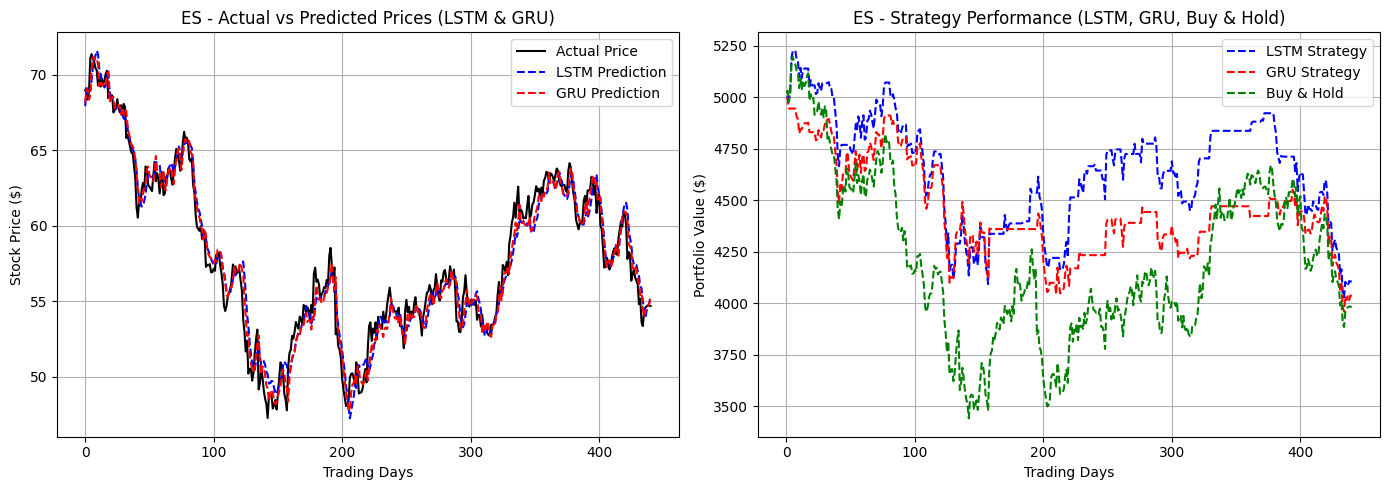

441 441 441


In [76]:
# Run the LSTM and GRU models, and evaluate trading strategies for Eversource Energy stock
train_and_predict_lstm_gru("ES")

[*********************100%***********************]  1 of 1 completed


Starting model for APA
Reloading Tuner from hyperparameter_tuning\APA_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 150
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0858 - val_loss: 0.0020
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 9.6379e-04 - val_loss: 0.0014
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 8.0781e-04 - val_loss: 0.0013
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 9.1113e-04 - val_loss: 0.0013
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 7.2685e-04 - val_loss: 0.0013
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.5224e-04 - val_loss: 0.0012
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 7.1846e-0

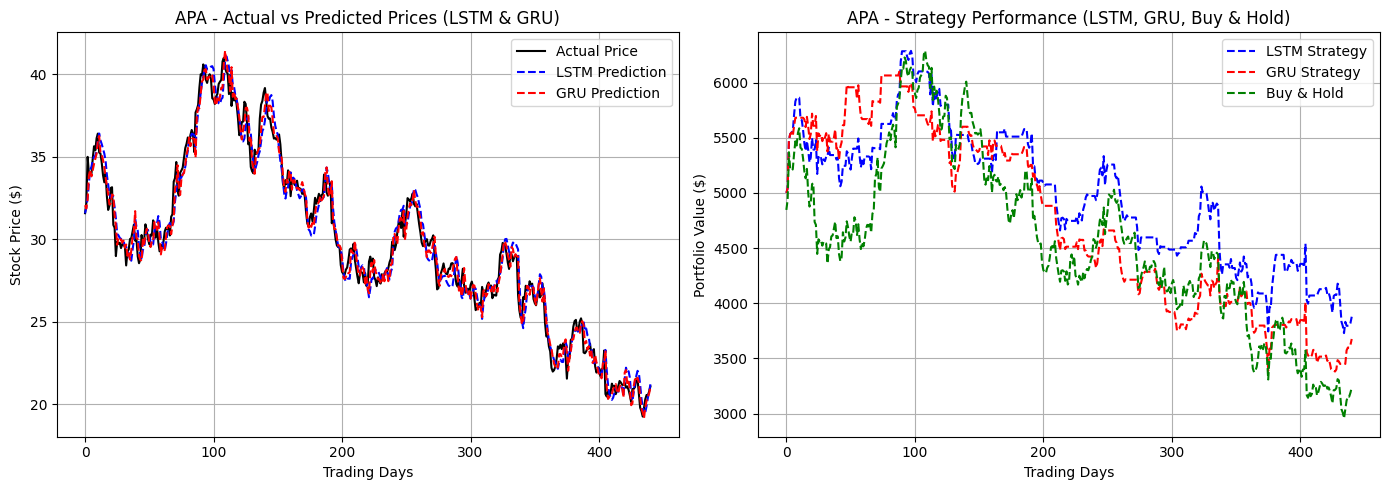

441 441 441


In [84]:
# Run the LSTM and GRU models, and evaluate trading strategies for APA Corporation stock
train_and_predict_lstm_gru("APA")

After implementing and testing the workflow for a single-stock portfolio, we extend the approach to a portfolio of 10 stocks, allocating 1.000 USD starting capital per stock. This allows us to evaluate the performance and risk of LSTM- and GRU-based trading strategies in a diversified setting, rather than relying on the behavior of a single asset. By spreading the capital across multiple stocks, we can observe how the strategies perform in combination and assess overall portfolio risk.

The `stocks_portfolio` function automates this process for multiple stocks. For each stock:
1. Trains LSTM and GRU models on historical data and generates price predictions.
2. Generates trading signals based on predicted vs actual prices.
3. Simulates portfolio performance using the predicted signals.
4. Aggregates individual stock portfolios into a combined multi-stock portfolio.
5. Calculates final portfolio value and Historical Value at Risk (VaR 5%).

In [87]:
def stocks_portfolio(stocks, start_capital_per_stock=1000, trade_cost=1):
    portfolio_lstm, portfolio_gru, portfolio_buy_hold = None, None, None
    indiv_lstm, indiv_gru, indiv_buy_hold = {}, {}, {}

    for stock in stocks:
        print(f"\nProcessing {stock}")
        df = yf.download(stock, start="2015-01-01", end="2024-12-31", auto_adjust=True)
        df = get_features(df)

        # Split into training and test sets
        train_df = df[df['Year'] <= 2022]
        test_df = df[df['Year'] >= 2023]

        train_data = train_df[features].values
        test_data = test_df[features].values

        # Scale features between 0 and 1
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train_data)
        test_scaled = scaler.transform(test_data)

        # Create sequences for RNN input
        X_train_full, y_train_full = create_sequences(train_scaled, seq_length)
        X_test, y_test = create_sequences(test_scaled, seq_length)

        # Split in Training und Validation
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

        # Train LSTM and GRU
        y_pred_lstm = train_model_rnn(X_train, y_train, X_val, y_val, X_test, y_test, rnn_type='LSTM', stock=stock)
        y_pred_gru = train_model_rnn(X_train, y_train, X_val, y_val, X_test, y_test, rnn_type='GRU',  stock=stock)

        # Rescale predictions back to original Close price
        close_min = scaler.data_min_[0]
        close_max = scaler.data_max_[0]
        y_test_rescaled = y_test * (close_max - close_min)+close_min
        y_pred_lstm_rescaled = y_pred_lstm.flatten()*(close_max - close_min)+close_min
        y_pred_gru_rescaled = y_pred_gru.flatten()*(close_max - close_min)+close_min

        # Generate trading signals
        signals_lstm = generate_trading_signals(y_test_rescaled, y_pred_lstm_rescaled)
        signals_gru = generate_trading_signals(y_test_rescaled, y_pred_gru_rescaled)

        # Open prices are used for executing buy/sell trades (Close prices for valuation)
        open_prices_test = test_df["Open"].iloc[seq_length:].values
        min_len = min(len(y_test_rescaled), len(signals_lstm), len(signals_gru), len(open_prices_test))
        y_true_aligned = y_test_rescaled[:min_len]
        signals_lstm_aligned = signals_lstm[:min_len]
        signals_gru_aligned = signals_gru[:min_len]
        open_prices_aligned = open_prices_test[:min_len]

        # Simulate trading strategies
        strategy_lstm = calculate_strategy_returns(y_true_aligned, signals_lstm_aligned, open_prices_aligned, start_capital_per_stock, trade_cost)
        strategy_gru = calculate_strategy_returns(y_true_aligned, signals_gru_aligned,  open_prices_aligned, start_capital_per_stock, trade_cost)
        strategy_buy_hold = calculate_buy_hold_returns(y_true_aligned, open_prices_aligned, start_capital_per_stock, trade_cost)

        # Store individual stock results
        indiv_lstm[stock] = strategy_lstm
        indiv_gru[stock] = strategy_gru
        indiv_buy_hold[stock] = strategy_buy_hold

        # Aggregate portfolios
        if portfolio_lstm is None:
            portfolio_lstm = strategy_lstm
            portfolio_gru = strategy_gru
            portfolio_buy_hold = strategy_buy_hold
        else:
            min_len = min(len(portfolio_lstm), len(strategy_lstm))
            portfolio_lstm = portfolio_lstm[:min_len] + strategy_lstm[:min_len]
            portfolio_gru = portfolio_gru[:min_len]  + strategy_gru[:min_len]
            portfolio_buy_hold = portfolio_buy_hold[:min_len] + strategy_buy_hold[:min_len]

    # Final portfolio values
    final_values = {
        'LSTM': portfolio_lstm[-1],
        'GRU': portfolio_gru[-1],
        'Buy & Hold': portfolio_buy_hold[-1]}

    # Total starting capital of the combined portfolio
    total_start_capital = start_capital_per_stock * len(stocks)

    # Calculate total portfolio return in %
    return_lstm = (portfolio_lstm[-1] - total_start_capital) / total_start_capital * 100
    return_gru = (portfolio_gru[-1] - total_start_capital) / total_start_capital * 100
    return_buy_hold = (portfolio_buy_hold[-1] - total_start_capital) / total_start_capital * 100
    
    print("\nTotal Portfolio Return (%):")
    print(f"LSTM Strategy: {return_lstm:.2f}%")
    print(f"GRU Strategy: {return_gru:.2f}%")
    print(f"Buy & Hold: {return_buy_hold:.2f}%")

    # Calculate daily returns
    def daily_returns(portfolio):
        return np.diff(portfolio)/portfolio[:-1]

    returns_lstm = daily_returns(portfolio_lstm)
    returns_gru = daily_returns(portfolio_gru)
    returns_buy_hold = daily_returns(portfolio_buy_hold)

    # Calculate Historical VaR (5%)
    historical_var ={
        'LSTM': np.percentile(returns_lstm, 5),
        'GRU':  np.percentile(returns_gru, 5),
        'Buy & Hold': np.percentile(returns_buy_hold, 5)}

    # Print results
    print("\nFinal portfolio values:")
    print(f"LSTM Strategy: {final_values['LSTM']:.2f}")
    print(f"GRU Strategy: {final_values['GRU']:.2f}")
    print(f"Buy & Hold: {final_values['Buy & Hold']:.2f}")

    print("\n5% Historical VaR:")
    print(f"LSTM Strategy: {historical_var['LSTM']:.4f}")
    print(f"GRU Strategy: {historical_var['GRU']:.4f}")
    print(f"Buy & Hold: {historical_var['Buy & Hold']:.4f}")

    return portfolio_lstm, portfolio_gru, portfolio_buy_hold, indiv_lstm, indiv_gru, indiv_buy_hold, final_values, historical_var

In [97]:
# Run the LSTM and GRU models, and evaluate trading strategies for portfolio with 10 stocks
stocks = ["MSCI","MCD","BA","PFE","INTC","MDLZ","AVY","BXP","ES","APA"]
portfolio_lstm, portfolio_gru, portfolio_buy_hold, indiv_lstm, indiv_gru, indiv_buy_hold, final_values, historical_var = stocks_portfolio(stocks)


Processing MSCI


[*********************100%***********************]  1 of 1 completed


Reloading Tuner from hyperparameter_tuning\MSCI_LSTM_tuning\tuner0.json

Best Hyperparameters for LSTM
Units: 100
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0100 - val_loss: 0.0020
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.6924e-04 - val_loss: 0.0015
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.5104e-04 - val_loss: 0.0013
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.2500e-04 - val_loss: 0.0014
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.7286e-04 - val_loss: 0.0012
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.3987e-04 - val_loss: 0.0011
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.2581e-04 - val_loss: 9.9801e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.2314e-04 - val_loss: 9.6530e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.2130e-04 - val_loss: 9.5359e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss:

[*********************100%***********************]  1 of 1 completed


Reloading Tuner from hyperparameter_tuning\MCD_LSTM_tuning\tuner0.json

Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0280 - val_loss: 7.9698e-04
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 4.3543e-04 - val_loss: 0.0013
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 3.8940e-04 - val_loss: 0.0011
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 3.3108e-04 - val_loss: 8.1303e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 2.7875e-04 - val_loss: 0.0010
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 2.8590e-04 - val_loss: 0.0011
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Reloading Tuner from hyperparameter_tuning\MCD_GRU_tuning\tuner0.json

Best Hyperparameters for GRU
Units: 150
Dropout Rate: 0.4
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.0412 - val_loss: 9.4538e-04
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0044 - val_l

[*********************100%***********************]  1 of 1 completed


Processing BA
Reloading Tuner from hyperparameter_tuning\BA_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.30000000000000004
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0501 - val_loss: 8.2145e-04
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0041 - val_loss: 7.8206e-04
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0033 - val_loss: 9.1182e-04
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0032 - val_loss: 6.6364e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0022 - val_loss: 5.3960e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0020 - val_loss: 6.4685e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0019 - val_loss: 6.1532e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0019 - val_loss: 7.1328e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0021 - val_loss: 7.5034e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0017 - val_loss: 4.6691e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

Reloading Tuner from hyperparameter_tuning\PFE_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0068 - val_loss: 0.0029
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 3.8961e-04 - val_loss: 0.0024
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 3.3527e-04 - val_loss: 0.0027
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 2.9176e-04 - val_loss: 0.0027
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 2.8187e-04 - val_loss: 0.0020
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 2.4764e-04 - val_loss: 0.0025
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 2.4576e-04 - val_loss: 0.0015
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 2.7330e-04 - val_loss: 0.0012
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 2.1695e-04 - val_loss: 0.0017
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 2.2761e-04 - val_loss: 0.0016
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step 

[*********************100%***********************]  1 of 1 completed


Processing INTC
Reloading Tuner from hyperparameter_tuning\INTC_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.1
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0431 - val_loss: 0.0014
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0012 - val_loss: 9.9100e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0012 - val_loss: 9.9860e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0012 - val_loss: 9.3029e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0012 - val_loss: 8.7081e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 9.2193e-04 - 

[*********************100%***********************]  1 of 1 completed


Processing MDLZ
Reloading Tuner from hyperparameter_tuning\MDLZ_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 100
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0199 - val_loss: 0.0017
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 7.1960e-04 - val_loss: 0.0016
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 7.9058e-04 - val_loss: 0.0011
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 6.4134e-04 - val_loss: 0.0010
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.8806e-04 - val_loss: 9.9584e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.9544e-04 - val_loss: 0.0012
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.0594e-04 - val_loss: 0.0011
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 5.5322e-04 - val_loss: 8.5262e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.0474e-04 - val_loss: 8.8700e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.9313e-04 - val_loss: 0.0011
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s

[*********************100%***********************]  1 of 1 completed


Processing AVY
Reloading Tuner from hyperparameter_tuning\AVY_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 100
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0184 - val_loss: 0.0049
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 4.1868e-04 - val_loss: 0.0018
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 2.9741e-04 - val_loss: 0.0011
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 3.4489e-04 - val_loss: 9.8251e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2.6955e-04 - val_loss: 9.1368e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.7500e-04 - val_loss: 0.0015
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.4415e-04 - val_loss: 0.0010
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.1807e-04 - val_loss: 9.1244e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 2.3946e-04 - val_loss: 8.9078e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.0434e-04 - val_loss: 8.3782e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed


Reloading Tuner from hyperparameter_tuning\BXP_LSTM_tuning\tuner0.json

Best Hyperparameters for LSTM
Units: 150
Dropout Rate: 0.30000000000000004
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0626 - val_loss: 0.0032
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0030 - val_loss: 0.0021
Ep

[*********************100%***********************]  1 of 1 completed

Reloading Tuner from hyperparameter_tuning\ES_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 200
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.0121 - val_loss: 0.0015
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 6.9902e-04 - val_loss: 0.0016
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 7.4873e-04 - val_loss: 0.0014
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 7.1867e-04 - val_loss: 0.0011
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 5.5228e-04 - val_loss: 0.0011
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 7.1630e-04 - val_loss: 0.0011
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 6.6696e-04 - val_loss: 9.4438e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 5.5645e-04 - val_loss: 9.5076e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 5.1723e-04 - val_loss: 0.0010
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 7.3803e-04 - val_loss: 8.2703e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 

[*********************100%***********************]  1 of 1 completed


Processing APA
Reloading Tuner from hyperparameter_tuning\APA_LSTM_tuning\tuner0.json



Best Hyperparameters for LSTM
Units: 150
Dropout Rate: 0.0
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0374 - val_loss: 0.0023
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 8.0166e-04 - val_loss: 0.0013
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 7.6926e-04 - val_loss: 0.0014
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 8.3013e-04 - val_loss: 0.0012
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 7.7120e-04 - val_loss: 0.0012
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 7.0008e-04 - val_loss: 0.0012
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 7.0533e-04 - val_loss: 0.0012
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.6209e-04 - val_loss: 0.0011
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.4691e-04 - val_loss: 0.0010
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - lo

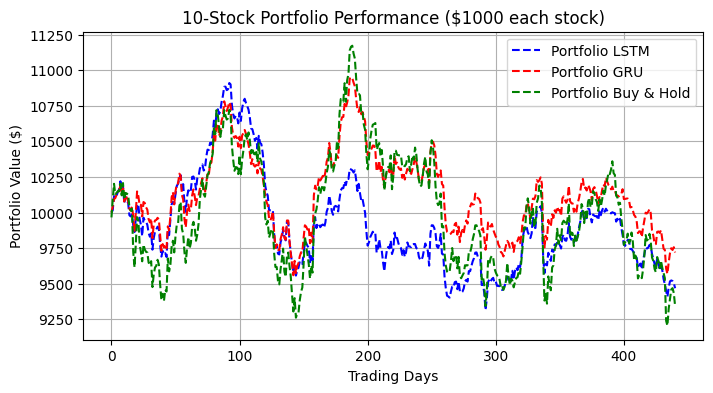

In [99]:
# Plot portfolio value comparison
plt.figure(figsize=(8,4))
plt.plot(portfolio_lstm, label="Portfolio LSTM", color='blue', linestyle='dashed')
plt.plot(portfolio_gru,  label="Portfolio GRU", color='red', linestyle='dashed')
plt.plot(portfolio_buy_hold, label="Portfolio Buy & Hold", color='green', linestyle='dashed')
plt.title("10-Stock Portfolio Performance ($1000 each stock)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()